In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2

In [2]:
import pathlib

train_dir = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/train"
test_dir = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test"
valid_dir = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid"
train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)
valid_dir = pathlib.Path(valid_dir)

In [3]:
batch_size = 64
img_height = 224
img_width = 224

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  #validation_split=0.40,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical",
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  valid_dir,
  #validation_split=0.40,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical",
  )

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical",
)

Found 5789 files belonging to 57 classes.
Found 1448 files belonging to 57 classes.
Found 1810 files belonging to 57 classes.


2024-08-08 18:36:27.723640: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-08-08 18:36:27.723663: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-08-08 18:36:27.723669: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-08-08 18:36:27.723685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-08 18:36:27.723695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
class_names = train_ds.class_names
print(class_names)

['Apogonidae_Apogon_binotatus', 'Apogonidae_Apogon_maculatus', 'Apogonidae_Fowleria_vaiulae', 'Apogonidae_Ostorhinchus_angustatus', 'Apogonidae_Pristiapogon_kallopterus', 'Blenniidae_Cirripectes_variolosus', 'Blenniidae_Ecsenius_pulcher', 'Blenniidae_Ecsenius_stictus', 'Blenniidae_Enchelyurus_ater', 'Chaenopsidae_Acanthemblemaria_aspera', 'Chaetodontidae_Chaetodon_quadrimaculatus', 'Cirrhitidae_Neocirrhites_armatus', 'Cirrhitidae_Paracirrhites_arcatus', 'Creediidae_Limnichthys_nitidus', 'Gobiidae_Aioliops_megastigma', 'Gobiidae_Eviota_albolineata', 'Gobiidae_Eviota_atriventris', 'Gobiidae_Eviota_melasma', 'Gobiidae_Fusigobius_neophytus', 'Gobiidae_Gobiodon_histrio', 'Gobiidae_Gobiodon_quinquestrigatus', 'Gobiidae_Istigobius_decoratus', 'Gobiidae_Koumansetta_rainfordi', 'Gobiidae_Nemateleotris_magnifica', 'Gobiidae_Paragobiodon_lacunicolus', 'Gobiidae_Paragobiodon_modestus', 'Gobiidae_Pleurosicya_labiata', 'Gobiidae_Priolepis_semidoliatus', 'Gobiidae_Trimma_macrophthalmus', 'Labridae_Go

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
normalization_layer = layers.Rescaling(1./255)

#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),  # Randomly zoom in on the image
  tf.keras.layers.RandomTranslation(0.1, 0.1),  # Randomly translate the image in horizontal and vertical directions
  tf.keras.layers.RandomContrast(0.2),  # Adjust the contrast of the image
  tf.keras.layers.RandomBrightness(0.2),  # Adjust the brightness of the image
  tf.keras.layers.RandomCrop(224, 224)  # Randomly crop the image to the target size
])

In [8]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False, 
    weights='imagenet', 
    pooling='avg',
    input_shape=(224, 224, 3)
)

base_model.trainable = False

#for layer in base_model.layers[:-10]:
#        layer.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
#x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

#input_model = base_model.input
#x = base_model.output

x = tf.keras.layers.Dense(
    1024,
    activation="relu",
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
)(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

output = tf.keras.layers.Dense(
    len(class_names), activation="softmax"
)(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy','AUC', 'Precision', 'Recall'],
)

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 57)             │        58,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,293,577 (27.82 MB)

 Trainable params: 1,372,217 (5.23 MB)

 Non-trainable params: 5,921,360 (22.59 MB)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

epochs=25

# Define callbacks
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6,
)
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)
    
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  callbacks=[
      early_stop,
      reduce_lr,
  ]
)

Epoch 1/25


2024-08-08 18:36:30.651732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


91/91 ━━━━━━━━━━━━━━━━━━━━ 38s 341ms/step - AUC: 0.6727 - Precision: 0.4174 - Recall: 0.0474 - accuracy: 0.1394 - loss: 38.0841 - val_AUC: 0.9453 - val_Precision: 1.0000 - val_Recall: 6.9061e-04 - val_accuracy: 0.5414 - val_loss: 35.1349 - learning_rate: 1.0000e-04
Epoch 2/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 23s 257ms/step - AUC: 0.9257 - Precision: 0.7837 - Recall: 0.2946 - accuracy: 0.4892 - loss: 33.8018 - val_AUC: 0.9785 - val_Precision: 0.9942 - val_Recall: 0.1181 - val_accuracy: 0.6961 - val_loss: 31.8542 - learning_rate: 1.0000e-04
Epoch 3/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 24s 261ms/step - AUC: 0.9631 - Precision: 0.8349 - Recall: 0.4430 - accuracy: 0.6092 - loss: 30.8418 - val_AUC: 0.9879 - val_Precision: 0.9689 - val_Recall: 0.3874 - val_accuracy: 0.7659 - val_loss: 28.8397 - learning_rate: 1.0000e-04
Epoch 4/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - AUC: 0.9753 - Precision: 0.8788 - Recall: 0.5612 - accuracy: 0.7076 - loss: 28.1601 - val_AUC: 0.9920 - val_Precision: 0.9593 - val_R

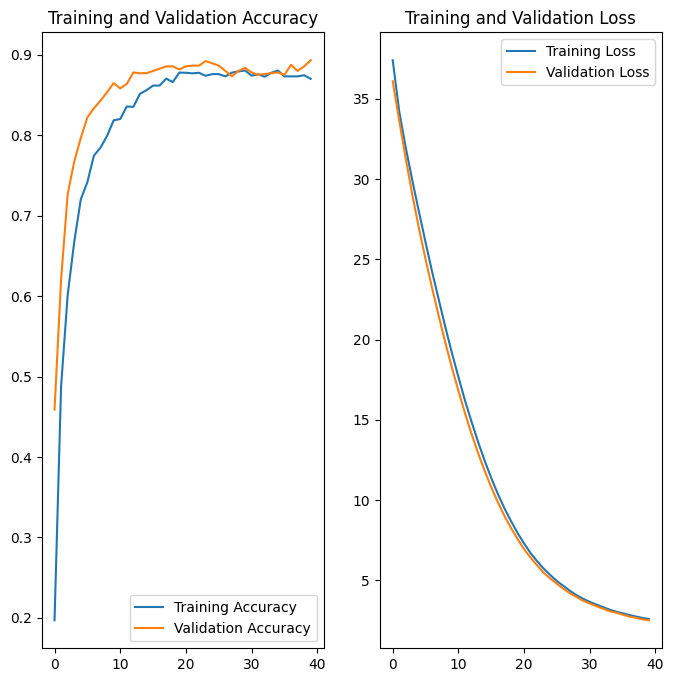

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
model.save("model.keras")

In [15]:
ft_model = tf.keras.models.load_model('model.keras')

ft_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 57)             │        58,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,038,013 (38.29 MB)

 Trainable params: 1,372,217 (5.23 MB)

 Non-trainable params: 5,921,360 (22.59 MB)

 Optimizer params: 2,744,436 (10.47 MB)

In [19]:
#model = load_model(model_path)
base_model = ft_model.layers[2]  # Assuming the base model is the second last layer

# Unfreeze the layers from `unfreeze_from`
for layer in ft_model.layers[2].layers[100:]:
    layer.trainable = True
    
ft_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 57)             │        58,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,038,013 (38.29 MB)

 Trainable params: 6,527,865 (24.90 MB)

 Non-trainable params: 765,712 (2.92 MB)

 Optimizer params: 2,744,436 (10.47 MB)

In [13]:
img = tf.keras.utils.load_img(
    "/Users/leonardo/Library/CloudStorage/GoogleDrive-leonardofonseca.r@gmail.com/My Drive/04_projects/CryptoVision/Data/training_v2/test/Blenniidae_Cirripectes_variolosus/fish_photo_4797.jpeg",
    target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(predictions[0]))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
This image most likely belongs to Blenniidae_Cirripectes_variolosus with a 98.72 percent confidence.


In [14]:
# Get the top 5 predictions and their confidence scores
top_5_indices = np.argsort(predictions[0])[-5:][::-1]
top_5_confidences = predictions[0][top_5_indices]
top_5_classes = [class_names[i] for i in top_5_indices]

# Print the top 5 predictions and their confidence scores
print("Top 5 predictions with confidence:")
for i, (cls, confidence) in enumerate(zip(top_5_classes, top_5_confidences)):
    print(f"{i + 1}. {cls} with a confidence of {100 * confidence:.2f}%")

Top 5 predictions with confidence:
1. Blenniidae_Cirripectes_variolosus with a confidence of 98.72%
2. Pseudochromidae_Cypho_purpurascens with a confidence of 0.22%
3. Gobiidae_Eviota_atriventris with a confidence of 0.16%
4. Cirrhitidae_Paracirrhites_arcatus with a confidence of 0.10%
5. Apogonidae_Apogon_maculatus with a confidence of 0.09%


In [20]:
# Model evaluation
accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - AUC: 0.9907 - Precision: 0.9000 - Recall: 0.7294 - accuracy: 0.8025 - loss: 15.7286
Test accuracy : [15.715445518493652, 0.8109305500984192, 0.9906172156333923, 0.9105022549629211, 0.7363367676734924]


In [21]:
model.metrics_names

['loss', 'compile_metrics']